<a href="https://colab.research.google.com/github/marlungu/gwu_rml/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

License
MIT License

Copyright (c) 2022 marianalungu@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Pythons imports

In [229]:
!pip install h2o
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
from sklearn import tree                                  # sklearn tree model for decision trees
from sklearn.model_selection import train_test_split      # for partitioning data
from sklearn.model_selection import cross_val_score       # for cross validation
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score # to assess decision tree perforamce

import itertools                                              # for cartesian product of parameters

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators


import warnings
warnings.filterwarnings('ignore')

# to upload local files
import io
from google.colab import files

import numpy as np                                   # array, vector, matrix calculations
import pandas as pd                                  # dataFrame handling

from matplotlib import pyplot as plt                 # plotting
import seaborn as sns                                # slightly better plotting

SEED = 12345                                         # ALWAYS use a random seed for better reproducibility

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 56 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 2 days
H2O_cluster_name:,H2O_from_python_unknownUser_0t1y2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.957 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [181]:
# print version information
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('sklearn version:', sklearn.__version__)

Python version: 3.10.12
sklearn version: 1.2.2


## Upload training data

In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
data = pd.read_csv('/content/drive/MyDrive/RML/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/RML/hmda_test_preprocessed.csv')

In [184]:
type(data) # what kind of Python object did we just create?

pandas.core.frame.DataFrame

In [185]:
data.keys() # what is stored in that Python object?

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')

## Basic Data Analysis

In [186]:
data

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160333,160333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0.365054,0.663316,0.244394,-0.215304,0.019094,-0.015361,1.585876,0
160334,160334,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1,0,-0.558366,0.552520,0.244394,-0.215304,-0.597602,-0.039268,1.585876,0
160335,160335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,9.599253,-0.463082,-4.091747,2.197776,9.084518,0.270486,0.397554,0
160336,160336,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.998089,0.552520,0.244394,-0.215304,-0.905950,-0.039614,-0.425131,0


In [187]:
data.shape # (rows,columns)

(160338, 23)

In [188]:
data.columns # names of columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')

In [189]:
data.isnull().any() # check for missing values

row_id                          False
black                            True
asian                            True
white                            True
amind                            True
hipac                            True
hispanic                         True
non_hispanic                     True
male                             True
female                           True
agegte62                         True
agelt62                          True
term_360                        False
conforming                      False
debt_to_income_ratio_missing    False
loan_amount_std                 False
loan_to_value_ratio_std         False
no_intro_rate_period_std        False
intro_rate_period_std           False
property_value_std              False
income_std                      False
debt_to_income_ratio_std        False
high_priced                     False
dtype: bool

In [190]:
data.describe() # basic descriptive statistics

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,137790.000000,137790.000000,137790.000000,137790.000000,137790.000000,137877.000000,137877.000000,86537.000000,86537.000000,...,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,80168.500000,0.078758,0.078678,0.835554,0.004434,0.002576,0.121072,0.878928,0.612617,0.387383,...,0.928027,0.000617,7.152490e-17,4.657539e-17,3.749075e-17,-1.554138e-16,4.963314e-18,-4.659754e-17,-6.817910e-16,0.096702
std,46285.738068,0.269361,0.269236,0.370681,0.066443,0.050693,0.326212,0.326212,0.487155,0.487155,...,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,40084.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,80168.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,120252.750000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,160337.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


## Visualize data results


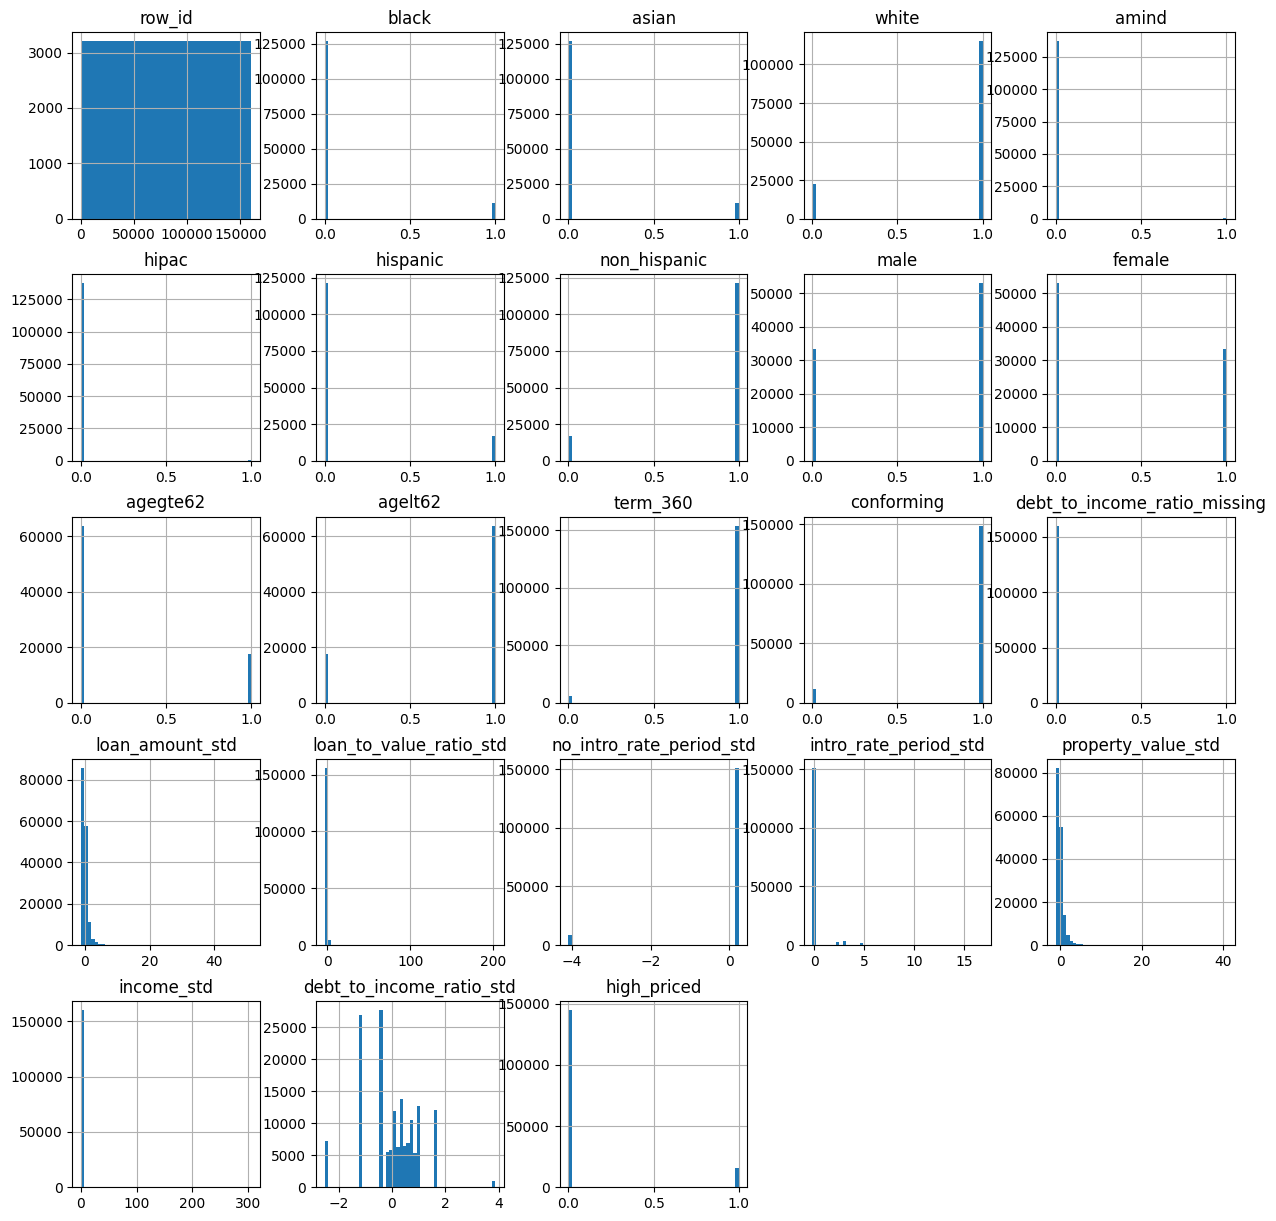

In [191]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [192]:
# Pearson correlation matrix
corr = data.corr()
corr

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
row_id,1.000000,0.000114,0.000235,-0.000533,0.000509,0.001374,-0.000652,0.000652,-0.004624,0.004624,...,-0.002691,0.003673,0.002838,0.002607,0.002252,-0.004191,0.002263,-0.002918,0.004616,0.004374
black,0.000114,1.000000,-0.085444,-0.659075,-0.019514,-0.014860,-0.080511,0.080511,-0.088304,0.088304,...,0.050286,-0.000175,-0.061082,0.083996,0.038811,-0.035465,-0.083174,-0.002129,0.102442,0.115477
asian,0.000235,-0.085444,1.000000,-0.658712,-0.019503,-0.014852,-0.090684,0.090684,0.039081,-0.039081,...,-0.124720,-0.002266,0.198016,-0.078726,-0.159728,0.135358,0.209666,0.001375,0.000245,-0.049599
white,-0.000533,-0.659075,-0.658712,1.000000,-0.150436,-0.114562,0.116579,-0.116579,0.040231,-0.040231,...,0.051316,0.001497,-0.097191,-0.006271,0.085712,-0.070990,-0.088790,0.000597,-0.078310,-0.049697
amind,0.000509,-0.019514,-0.019503,-0.150436,1.000000,-0.003392,0.031046,-0.031046,-0.001239,0.001239,...,0.010933,-0.001716,-0.015283,0.008204,0.007099,-0.007058,-0.016642,0.000509,0.009084,0.003893
hipac,0.001374,-0.014860,-0.014852,-0.114562,-0.003392,1.000000,0.018406,-0.018406,0.001603,-0.001603,...,0.005636,0.004266,0.003604,0.006903,0.006057,-0.002104,-0.000541,-0.001021,0.015083,0.008122
hispanic,-0.000652,-0.080511,-0.090684,0.116579,0.031046,0.018406,1.000000,-1.000000,0.028959,-0.028959,...,0.067856,-0.003478,-0.063776,0.065970,0.054880,-0.047253,-0.082635,-0.007892,0.141731,0.137151
non_hispanic,0.000652,0.080511,0.090684,-0.116579,-0.031046,-0.018406,-1.000000,1.000000,-0.028959,0.028959,...,-0.067856,0.003478,0.063776,-0.065970,-0.054880,0.047253,0.082635,0.007892,-0.141731,-0.137151
male,-0.004624,-0.088304,0.039081,0.040231,-0.001239,0.001603,0.028959,-0.028959,1.000000,-1.000000,...,-0.075416,-0.001054,0.109125,0.036810,-0.033185,0.026166,0.086676,0.003487,-0.043120,-0.033703
female,0.004624,0.088304,-0.039081,-0.040231,0.001239,-0.001603,-0.028959,0.028959,-1.000000,1.000000,...,0.075416,0.001054,-0.109125,-0.036810,0.033185,-0.026166,-0.086676,-0.003487,0.043120,0.033703


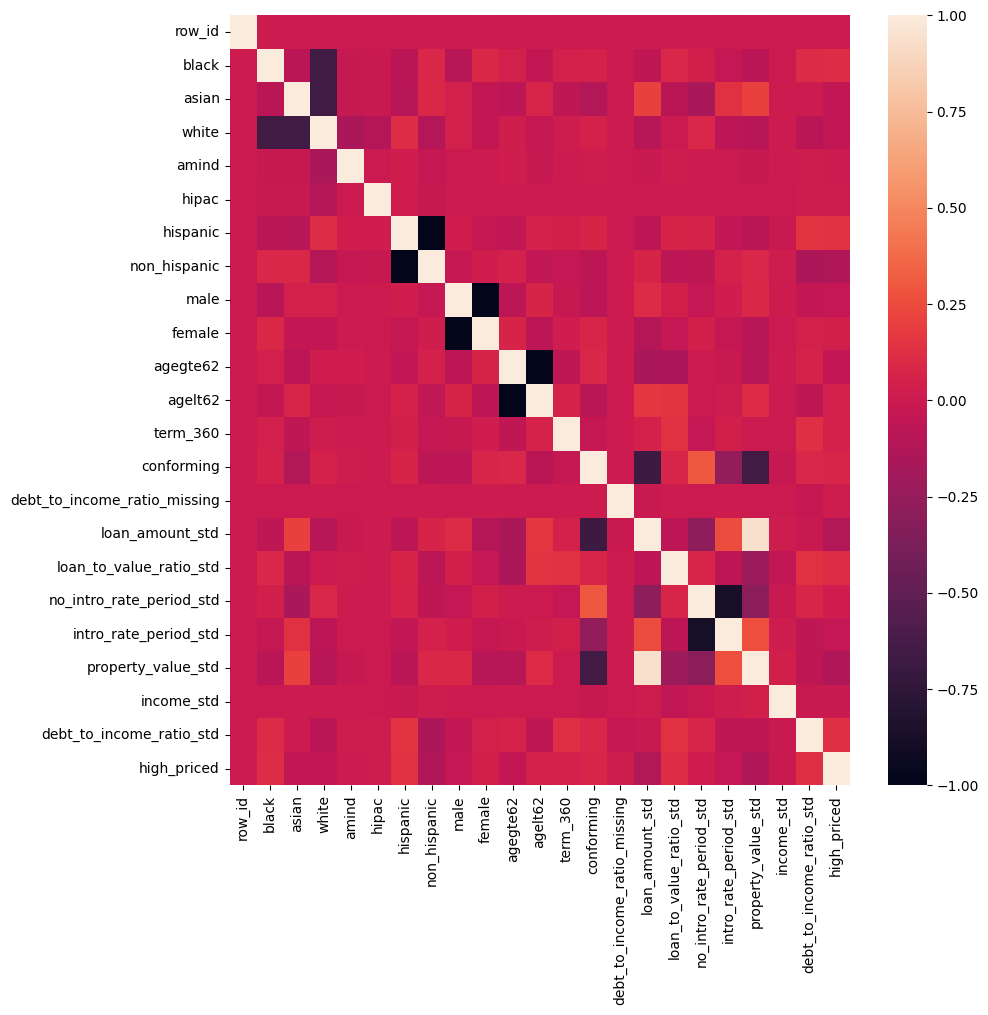

In [193]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

## Train decision tree

In [198]:
# assign basic modeling roles
# do not put demographic variables into a financial model!
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [201]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


## Split data into train and validation partitions




In [203]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12],
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# EBM grid search
best_ebm, ebm_grid_frame = ebm_grid(train,valid, x_names, y_name, gs_params=gs_params, n_models=10,
                                    early_stopping_rounds=100, seed=SEED)


Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8218.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

In [213]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8253.


## Score validation data with model

In [217]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.165646
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.314594
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.022284
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015600
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004888


In [218]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree

In [219]:
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.

    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    # if the line below fails for you, try instead:
    #gv_args = str('-cp ' + h2o_jar_path +
    #              ' hex.genmodel.tools.PrintMojo --tree 0 -i "'
    #              + mojo_path + '" -o').split()
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', '"' + str(title) + '"']

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)


In [220]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    # construct call to generate PNG from
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)
    _ = subprocess.call(png_args)

## Plot the tree for human interpretation

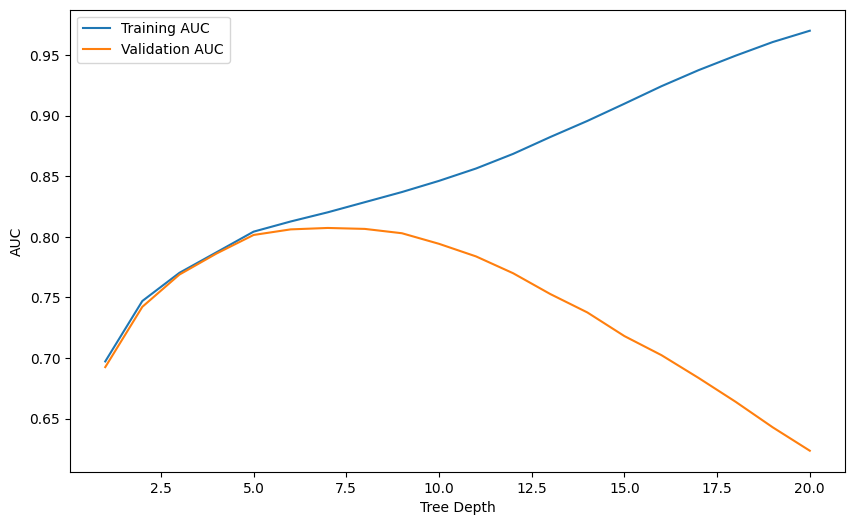

In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

train_aucs = []
valid_aucs = []
depth_range = range(1, 21)

for depth in depth_range:
    # Train the model with specific depth
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    # Compute the training AUC
    train_pred = clf.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_pred)
    train_aucs.append(train_auc)

    # Compute the validation AUC
    valid_pred = clf.predict_proba(X_val)[:, 1]
    valid_auc = roc_auc_score(y_val, valid_pred)
    valid_aucs.append(valid_auc)

# Plot the training and validation AUCs vs tree depth
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_aucs, label='Training AUC')
plt.plot(depth_range, valid_aucs, label='Validation AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC')
plt.legend()
plt.show()


## View same results as a table, using pandas iloc to remove first column of table

In [222]:
# Creating DataFrame
results_df = pd.DataFrame({
    'Tree Depth': depth_range,
    'Training AUC': train_aucs,
    'Validation AUC': valid_aucs
})

# If you want to remove the first column, use .iloc
results_df = results_df.iloc[:, 1:]

print(results_df)


    Training AUC  Validation AUC
0       0.697141        0.692440
1       0.747007        0.742198
2       0.770244        0.768801
3       0.787190        0.786166
4       0.804219        0.801483
5       0.812611        0.806100
6       0.820184        0.807270
7       0.828544        0.806489
8       0.836905        0.802915
9       0.846124        0.794189
10      0.856340        0.783777
11      0.868401        0.769902
12      0.882286        0.752769
13      0.895562        0.737576
14      0.909777        0.718061
15      0.924238        0.702308
16      0.937470        0.683528
17      0.949437        0.663831
18      0.960672        0.642775
19      0.970011        0.623467


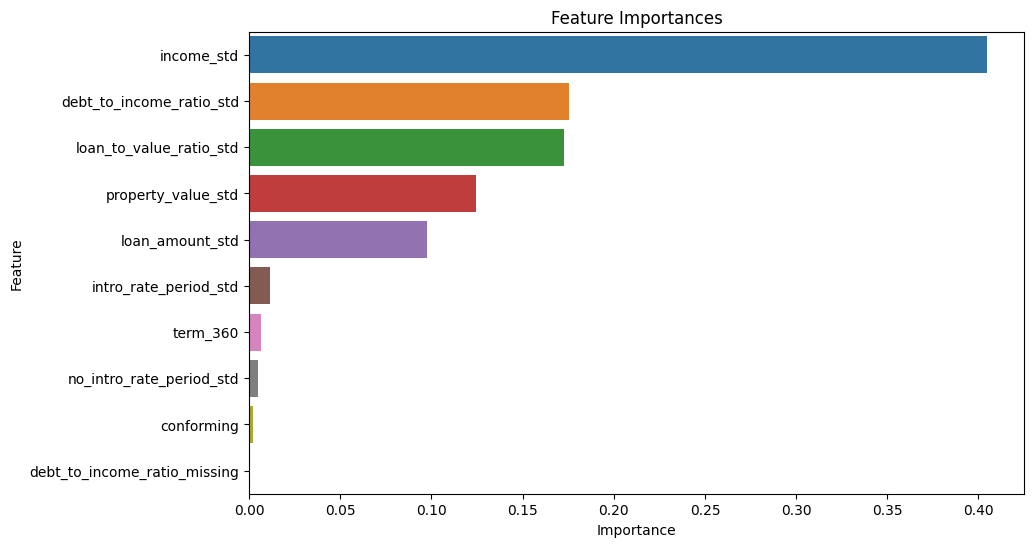

In [223]:
import matplotlib.pyplot as plt

# Let's assume you have a DecisionTreeClassifier model named "clf"
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

importances = clf.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': x_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()


 ## Function to create confusion matrices

In [224]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

## Function to calculate AIR

In [225]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


In [226]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = f1_frame.append(row_dict, ignore_index=True)

    del temp_df

    return f1_frame

In [227]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid

## Bias testing

In [230]:
from sklearn.metrics import f1_score          # for selecting model cutoffs


In [231]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.233938  0.384777
2    0.02  0.262541  0.479048
3    0.03  0.280733  0.530685
4    0.04  0.295953  0.569783
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3666 achieved at cutoff: 0.18 with accuracy: 0.7927.


## calculate confusion matrices
1. across race groups
2. calculate confusion matrices at standard cutoff 0.15
3. calculate AIR


In [233]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()


Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       470       911
predicted: 0       194      1617

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        95       176
predicted: 0        53      2926

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1965      6117
predicted: 0      1200     25243

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1036      3122
predicted: 0       628     11046

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       847      2175
predicted: 0       393      6617



In [235]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.15, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))


Adverse impact ratio for Asian people vs. White people: 1.208
Adverse impact ratio for Black people vs. White people: 0.739
Adverse impact ratio for Females vs. Males: 0.942


In [236]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))


Male proportion accepted: 0.737
Female proportion accepted: 0.699
Adverse impact ratio for Females vs. Males: 0.948


## Bias Remediation

In [237]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
22,0.22,0.356794,0.832942,0.816260
23,0.23,0.350179,0.841156,0.843019
24,0.24,0.341709,0.850161,0.864101
25,0.25,0.330154,0.858313,0.878680
26,0.26,0.316466,0.865155,0.887407


In [238]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.128
Adverse impact ratio for Black people vs. White people: 0.816
Adverse impact ratio for Females vs. Males: 0.965
